In [1]:
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
)
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

### Reading The CSV Files

In [2]:
BAF = pd.read_csv("Bank Account Fraud/Base.csv")

In [3]:
BAF.shape

(1000000, 32)

In [4]:
BAF.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [5]:
BAF.tail()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
999995,0,0.8,0.124690,-1,143,30,0.051348,-0.826239,AB,530,...,0,1500.0,0,INTERNET,16.967770,other,0,1,0,7
999996,0,0.9,0.824544,-1,193,30,0.009591,0.008307,AC,408,...,1,1000.0,0,INTERNET,1.504109,macintosh,0,1,0,7
999997,0,0.8,0.140891,-1,202,10,0.059287,50.609995,AA,749,...,0,200.0,0,INTERNET,16.068595,other,0,1,0,7
999998,0,0.9,0.002480,52,3,30,0.023357,-1.313387,AB,707,...,0,200.0,0,INTERNET,1.378683,linux,1,1,0,7
999999,0,0.6,0.993391,-1,174,30,0.020422,14.942456,AA,655,...,1,200.0,0,INTERNET,1.947926,other,1,1,0,7


In [6]:
BAF['fraud_bool'].value_counts()

fraud_bool
0    988971
1     11029
Name: count, dtype: int64

### Checking for Duplicates

In [7]:
print(f'Number of duplicated examples: {len(BAF.loc[BAF.duplicated()])}')
# There are no duplicates in the dataset

Number of duplicated examples: 0


### Checking for Nulls

In [8]:
BAF.isnull().sum().sort_values(ascending=False).head(10)
# There are no nulls in the dataset

fraud_bool                   0
income                       0
device_fraud_count           0
device_distinct_emails_8w    0
keep_alive_session           0
device_os                    0
session_length_in_minutes    0
source                       0
foreign_request              0
proposed_credit_limit        0
dtype: int64

### Changing the missing values represented with -1 to nulls in terms of %

In [9]:
BAF_replace_nulls = BAF.replace(-1, np.nan)
BAF_replace_nulls.loc[BAF['intended_balcon_amount'] < 0, 'intended_balcon_amount'] = np.nan

In [10]:
missing_by_class = BAF_replace_nulls.groupby('fraud_bool').apply(
    lambda n: (n.isnull().mean() * 100).round(2)
).T.sort_values(by=0, ascending=False).head(10)
print(missing_by_class)


fraud_bool                        0      1
intended_balcon_amount        74.09  88.38
prev_address_months_count     71.06  91.89
bank_months_count             25.23  37.54
current_address_months_count   0.43   0.13
session_length_in_minutes      0.20   0.16
credit_risk_score              0.05   0.00
device_distinct_emails_8w      0.04   0.04
foreign_request                0.00   0.00
phone_mobile_valid             0.00   0.00
has_other_cards                0.00   0.00


/var/folders/2r/mv3psfc9023ck75szgbr9gxr0000gn/T/ipykernel_91269/879491053.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_class = BAF_replace_nulls.groupby('fraud_bool').apply(


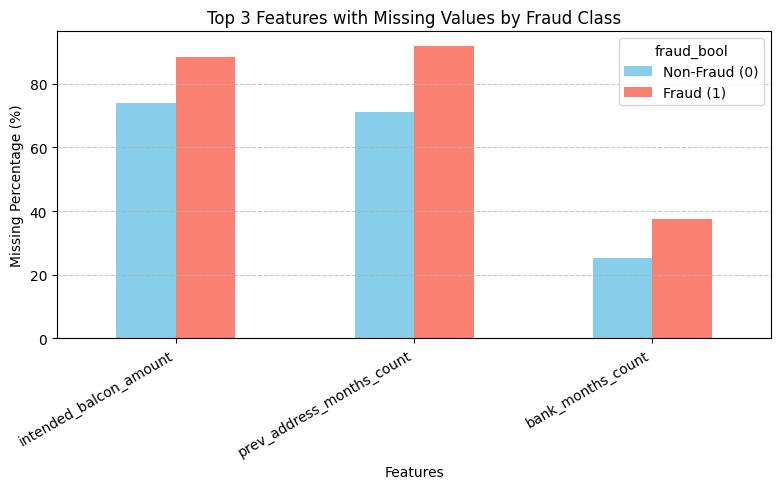

In [ ]:
missing_nonzero = missing_by_class[(missing_by_class > 0).any(axis=1)]

top3_missing = missing_nonzero.sort_values(by=0, ascending=False).head(3)

top3_missing.plot(kind='bar', figsize=(8,5), color=['skyblue', 'salmon'])

plt.title('Top 3 Features with Missing Values by Fraud Class')
plt.ylabel('Missing Percentage (%)')
plt.xlabel('Features')
plt.xticks(rotation=30, ha='right')
plt.legend(title='fraud_bool', labels=['Non-Fraud (0)', 'Fraud (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Decided not to drop the mission column because in the application, it might not be a compuslory field and leaving it empty might be valid

In [12]:
#Cehcking for nulls again for origial DF incase (BAF)
(BAF.isnull().mean()*100).sort_values(ascending=False).head(10)

fraud_bool                   0.0
income                       0.0
device_fraud_count           0.0
device_distinct_emails_8w    0.0
keep_alive_session           0.0
device_os                    0.0
session_length_in_minutes    0.0
source                       0.0
foreign_request              0.0
proposed_credit_limit        0.0
dtype: float64

In [13]:
for col in BAF.columns:
    print(f"\n--- {col} ---")
    print(BAF[col].value_counts())



--- fraud_bool ---
fraud_bool
0    988971
1     11029
Name: count, dtype: int64

--- income ---
income
0.9    221419
0.1    157449
0.8    146650
0.6    111973
0.7    105109
0.4     81364
0.2     69345
0.5     55858
0.3     50833
Name: count, dtype: int64

--- name_email_similarity ---
name_email_similarity
0.389347    2
0.533055    2
0.670345    2
0.012690    2
0.621812    2
           ..
0.858563    1
0.794049    1
0.813372    1
0.895561    1
0.993391    1
Name: count, Length: 998861, dtype: int64

--- prev_address_months_count ---
prev_address_months_count
-1      712920
 11      11475
 28      10275
 29      10150
 10      10082
         ...  
 374         1
 5           1
 375         1
 383         1
 381         1
Name: count, Length: 374, dtype: int64

--- current_address_months_count ---
current_address_months_count
6      16376
7      16270
8      16089
5      15896
9      15688
       ...  
413        1
419        1
403        1
424        1
428        1
Name: count, Length:

In [14]:
BAF = BAF.drop('device_fraud_count', axis= 1)

### Checking the Data Types

In [15]:
BAF.dtypes

fraud_bool                            int64
income                              float64
name_email_similarity               float64
prev_address_months_count             int64
current_address_months_count          int64
customer_age                          int64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                          int64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                  int64
date_of_birth_distinct_emails_4w      int64
employment_status                    object
credit_risk_score                     int64
email_is_free                         int64
housing_status                       object
phone_home_valid                      int64
phone_mobile_valid                    int64
bank_months_count                     int64
has_other_cards                 

In [16]:
# Listing the Boolean features and changing them to Boolean Type
boolean_features = ['fraud_bool', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'foreign_request', 'keep_alive_session']
BAF[boolean_features] = BAF[boolean_features].astype(bool)

# Export to CSV for tableau ANalysis

In [17]:
BAF.to_csv('BAF_tableau.csv')

### Checking for Outliers

In [18]:
BAF_num = BAF.select_dtypes(include= ['number'])

In [19]:
def iqr_outliers(outliers):
    q1 = outliers.quantile(0.25)
    q3 = outliers.quantile(0.75)
    iqr = q3 - q1
    lower_whisker = q1 - 1.5*iqr
    upper_whisker = q3 + 1.5*iqr
    return lower_whisker, upper_whisker

In [20]:
outliers_col = []
for col in BAF_num.columns:
    lower, upper = iqr_outliers(BAF_num[col])
    if ((BAF_num[col].min()) < lower) | ((BAF_num[col].max()) > upper):
        outliers_col.append(col)
outliers_col

['prev_address_months_count',
 'current_address_months_count',
 'customer_age',
 'days_since_request',
 'intended_balcon_amount',
 'zip_count_4w',
 'velocity_6h',
 'velocity_24h',
 'bank_branch_count_8w',
 'date_of_birth_distinct_emails_4w',
 'credit_risk_score',
 'proposed_credit_limit',
 'session_length_in_minutes',
 'device_distinct_emails_8w']

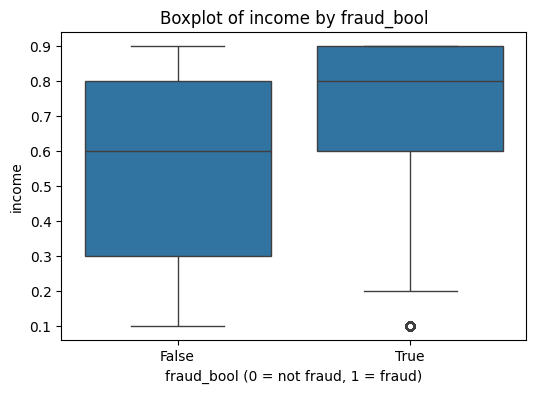

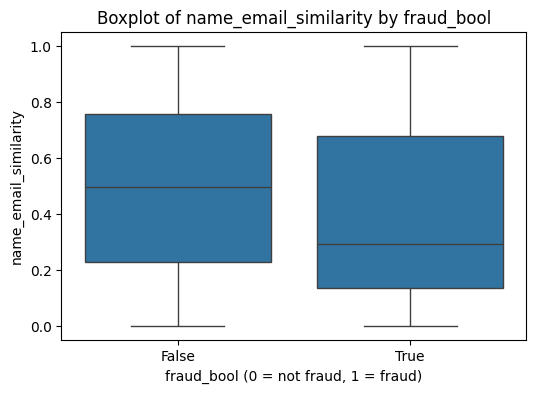

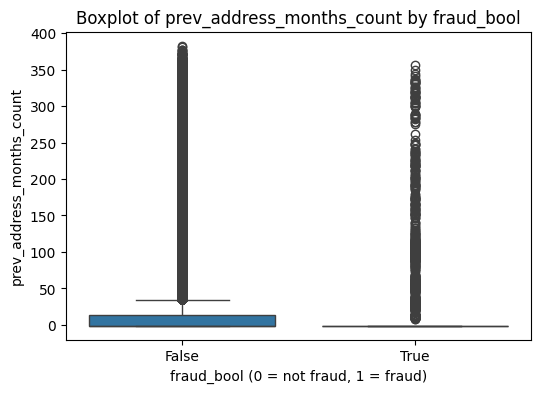

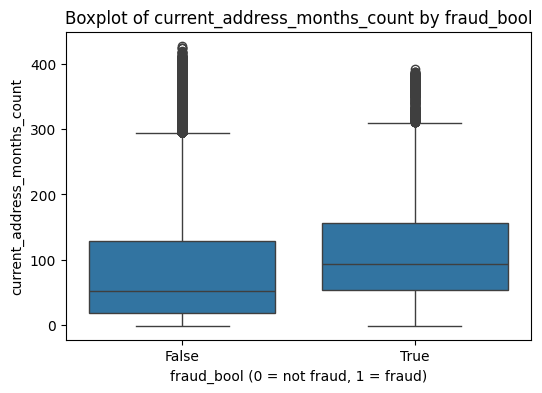

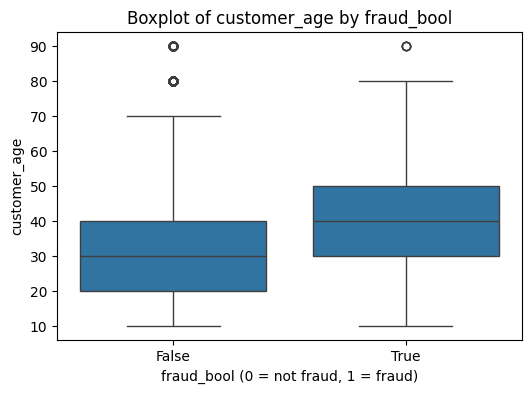

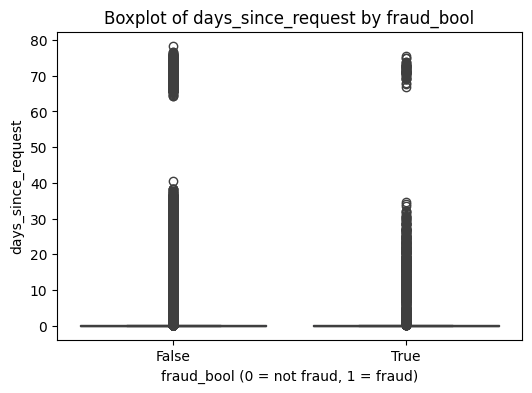

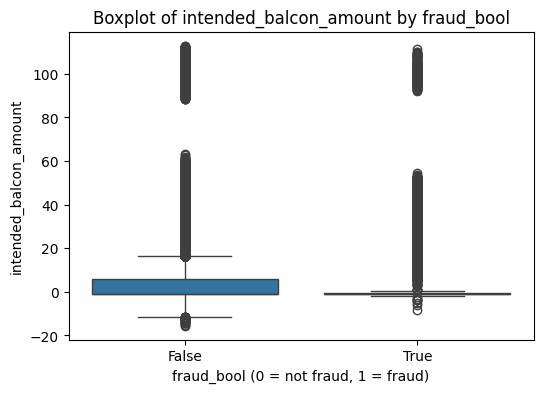

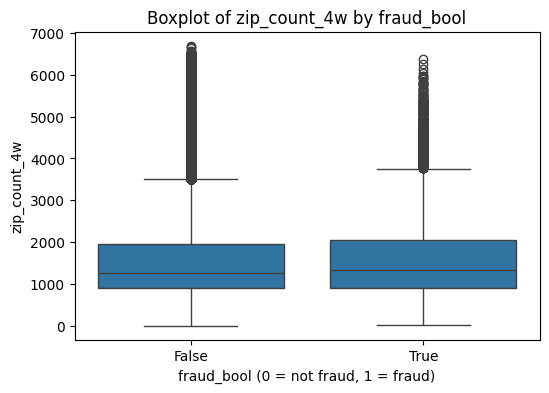

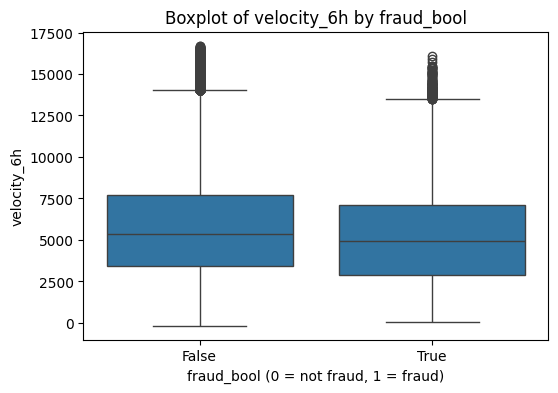

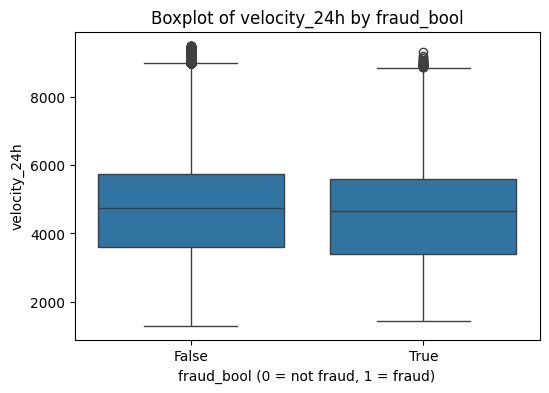

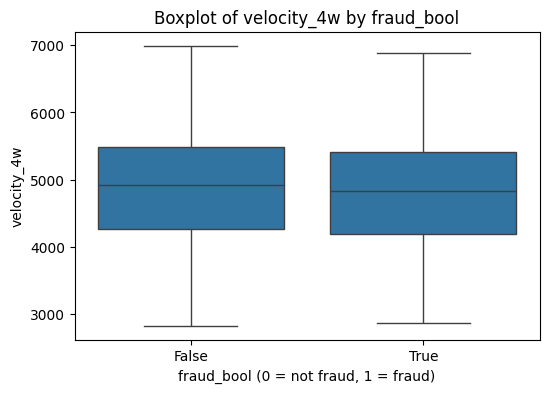

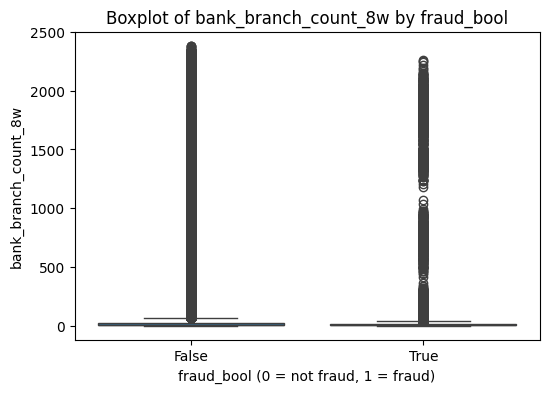

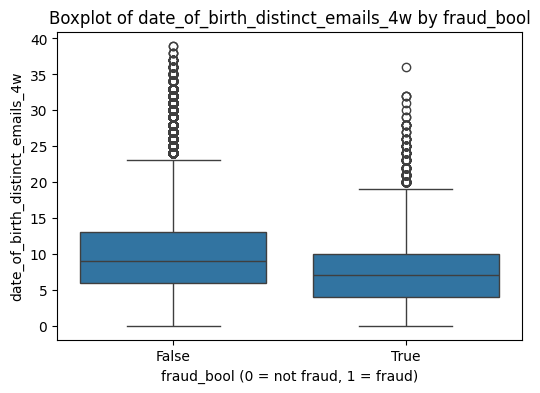

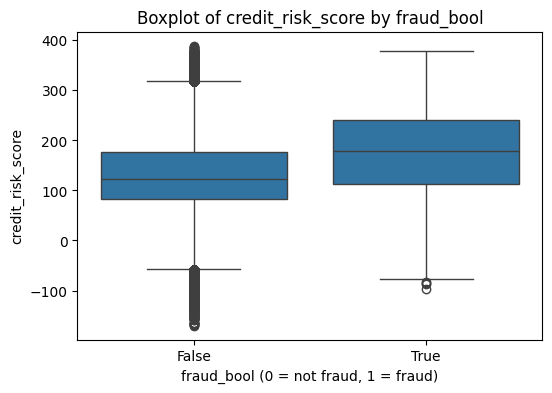

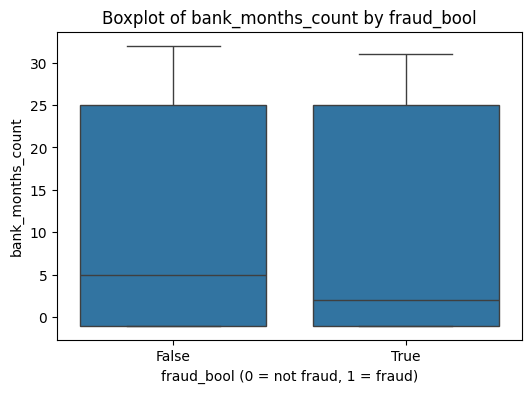

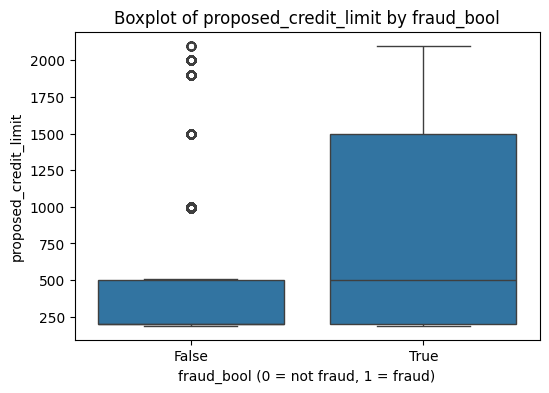

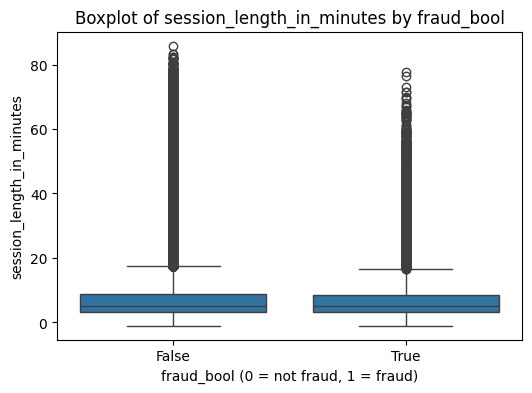

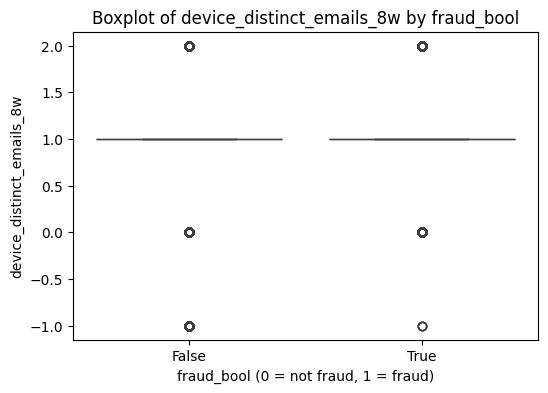

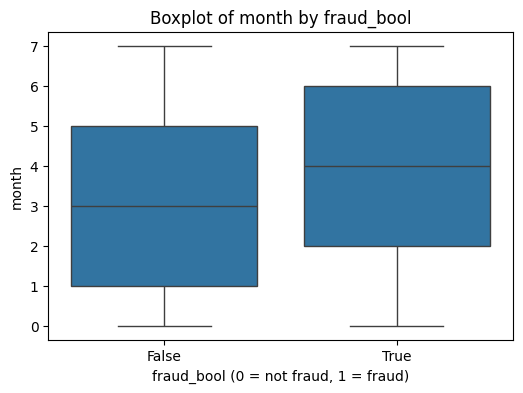

In [ ]:
numeric_cols = BAF_num.select_dtypes(include=['int64', 'float64'])

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='fraud_bool', y=col, data=BAF, showfliers=True)
    plt.title(f'Boxplot of {col} by fraud_bool')
    plt.xlabel('fraud_bool (0 = not fraud, 1 = fraud)')
    plt.ylabel(col)
    plt.show()

# Checking Imbalance

In [22]:
BAF['fraud_bool'].value_counts()

fraud_bool
False    988971
True      11029
Name: count, dtype: int64

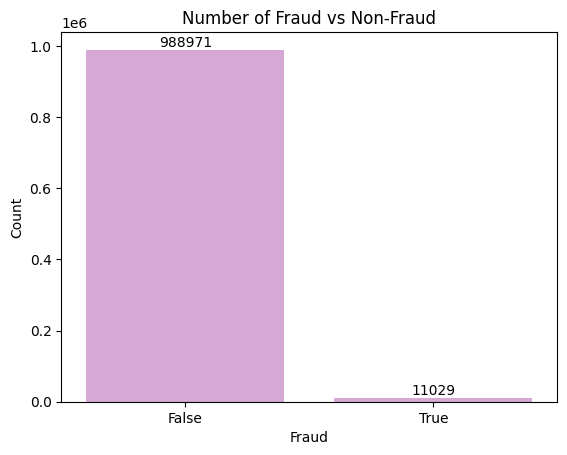

In [23]:
ax = sns.countplot(x='fraud_bool', data=BAF, color= 'plum')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.title("Number of Fraud vs Non-Fraud")

ax.bar_label(ax.containers[0])
plt.show()

In [24]:
BAF_obj = BAF.select_dtypes(include= ['object'])

In [25]:
BAF_obj.columns

Index(['payment_type', 'employment_status', 'housing_status', 'source',
       'device_os'],
      dtype='object')

In [26]:
for col in BAF_obj.columns:
    print(f"\nColumn: {col}")
    print(BAF_obj[col].value_counts())


Column: payment_type
payment_type
AB    370554
AA    258249
AC    252071
AD    118837
AE       289
Name: count, dtype: int64

Column: employment_status
employment_status
CA    730252
CB    138288
CF     44034
CC     37758
CD     26522
CE     22693
CG       453
Name: count, dtype: int64

Column: housing_status
housing_status
BC    372143
BB    260965
BA    169675
BE    169135
BD     26161
BF      1669
BG       252
Name: count, dtype: int64

Column: source
source
INTERNET    992952
TELEAPP       7048
Name: count, dtype: int64

Column: device_os
device_os
other        342728
linux        332712
windows      263506
macintosh     53826
x11            7228
Name: count, dtype: int64


In [27]:
for col in BAF_obj.columns:
    dummies = pd.get_dummies(BAF[col], prefix=col, drop_first= False)
    BAF = pd.concat([BAF, dummies], axis=1)
BAF.drop(columns=BAF_obj.columns, inplace=True)

In [28]:
BAF.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w',
       'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
       'credit_risk_score', 'email_is_free', 'phone_home_valid',
       'phone_mobile_valid', 'bank_months_count', 'has_other_cards',
       'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes',
       'keep_alive_session', 'device_distinct_emails_8w', 'month',
       'payment_type_AA', 'payment_type_AB', 'payment_type_AC',
       'payment_type_AD', 'payment_type_AE', 'employment_status_CA',
       'employment_status_CB', 'employment_status_CC', 'employment_status_CD',
       'employment_status_CE', 'employment_status_CF', 'employment_status_CG',
       'housing_status_BA', 'housing_status_BB', 'housing_status_BC',
       'housing_status_BD',

# Correlation

In [29]:
BAF = BAF[[col for col in BAF.columns if col != 'fraud_bool'] + ['fraud_bool']]

In [30]:
BAF_corr = BAF.corr()
BAF_corr.to_csv('corr.csv')

# Model

In [31]:
feature_col = [
       'income', 'name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'credit_risk_score',
       'email_is_free', 'phone_home_valid', 'phone_mobile_valid',
       'bank_months_count', 'has_other_cards', 'proposed_credit_limit',
       'foreign_request', 'session_length_in_minutes', 'keep_alive_session',
       'device_distinct_emails_8w', 'month', 'payment_type_AA',
       'payment_type_AB', 'payment_type_AC', 'payment_type_AD',
       'payment_type_AE', 'employment_status_CA', 'employment_status_CB',
       'employment_status_CC', 'employment_status_CD', 'employment_status_CE',
       'employment_status_CF', 'employment_status_CG', 'housing_status_BA',
       'housing_status_BB', 'housing_status_BC', 'housing_status_BD',
       'housing_status_BE', 'housing_status_BF', 'housing_status_BG',
       'source_INTERNET', 'source_TELEAPP', 'device_os_linux',
       'device_os_macintosh', 'device_os_other', 'device_os_windows',
       'device_os_x11']

# Split Train Test Set

In [32]:
BAF.month.value_counts()

month
3    150936
2    136979
0    132440
4    127691
1    127620
5    119323
6    108168
7     96843
Name: count, dtype: int64

In [33]:
BAF_train = BAF[BAF['month'] < 6].copy()
BAF_test  = BAF[BAF['month'] >= 6].copy()
y_col = 'fraud_bool'

In [34]:
X_train = BAF_train.drop(columns=[y_col])
y_train = BAF_train[y_col]
X_test = BAF_test.drop(columns=[y_col])
y_test = BAF_test[y_col]

# Log Regression Model

In [35]:
# Undersample the file for Log Regression first
rus = RandomUnderSampler(sampling_strategy=0.2, random_state=222)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

In [36]:
scaler = StandardScaler()
X_under_scale = scaler.fit_transform(X_train_under)
X_test_scale   = scaler.transform(X_test)

In [37]:
log_reg = LogisticRegression(solver='liblinear', max_iter=1000)
log_reg.fit(X_under_scale, y_train_under)

y_pred = log_reg.predict(X_test_scale)
y_proba = log_reg.predict_proba(X_test_scale)[:, 1]


In [38]:
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


ROC-AUC Score: 0.8781713594356355

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.97      0.98    202133
        True       0.17      0.38      0.23      2878

    accuracy                           0.96    205011
   macro avg       0.58      0.68      0.61    205011
weighted avg       0.98      0.96      0.97    205011


Confusion Matrix:
 [[196666   5467]
 [  1788   1090]]


# Trying various Features

In [39]:
core = [
    'income', 'customer_age', 'credit_risk_score', 'bank_months_count',
    'proposed_credit_limit', 'intended_balcon_amount'
]

identity = [
    'name_email_similarity', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid',
    'has_other_cards', 'foreign_request'
]

address = [
    'prev_address_months_count', 'current_address_months_count', 'zip_count_4w',
    'bank_branch_count_8w'
]

behavior = [
    'days_since_request', 'velocity_6h', 'velocity_24h', 'velocity_4w', 
    'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w'
]

socioeconomic = [
    'payment_type_AA', 'payment_type_AB', 'payment_type_AC', 'payment_type_AD',
    'payment_type_AE', 'employment_status_CA', 'employment_status_CB', 'employment_status_CC',
    'employment_status_CD', 'employment_status_CE', 'employment_status_CF',
    'employment_status_CG', 'housing_status_BA', 'housing_status_BB', 'housing_status_BC',
    'housing_status_BD', 'housing_status_BE', 'housing_status_BF', 'housing_status_BG',
    'source_INTERNET', 'source_TELEAPP'
]

device_os = [
    'device_os_linux', 'device_os_macintosh', 'device_os_other', 'device_os_windows',
    'device_os_x11'
]


all_features_list = {
    'income', 'customer_age', 'credit_risk_score', 'bank_months_count',
    'proposed_credit_limit', 'intended_balcon_amount',
    'name_email_similarity', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid',
    'has_other_cards', 'foreign_request',
    'prev_address_months_count', 'current_address_months_count', 'zip_count_4w',
    'bank_branch_count_8w',
    'days_since_request', 'velocity_6h', 'velocity_24h', 'velocity_4w', 
    'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w',
    'payment_type_AA', 'payment_type_AB', 'payment_type_AC', 'payment_type_AD',
    'payment_type_AE', 'employment_status_CA', 'employment_status_CB', 'employment_status_CC',
    'employment_status_CD', 'employment_status_CE', 'employment_status_CF',
    'employment_status_CG', 'housing_status_BA', 'housing_status_BB', 'housing_status_BC',
    'housing_status_BD', 'housing_status_BE', 'housing_status_BF', 'housing_status_BG',
    'source_INTERNET', 'source_TELEAPP',
    'device_os_linux', 'device_os_macintosh', 'device_os_other', 'device_os_windows',
    'device_os_x11',
    'date_of_birth_distinct_emails_4w'
}

feature_sets = {
    "core": core,
    "core_plus_identity": core + identity,
    "core_plus_behavior": core + behavior,
    "core_plus_address": core + address,
    "core_plus_socioeconomic": core + socioeconomic,
    "core_plus_device_os": core + device_os,
    "all_features": all_features_list
}

feature_sets['all_features'] = list(feature_sets['all_features'])


In [ ]:
results = []

for name, features in feature_sets.items():
    X_train_sub = X_train_under[features]
    X_test_sub  = X_test[features]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_sub)
    X_test_scaled  = scaler.transform(X_test_sub)

    model = LogisticRegression(
        solver='liblinear',
        max_iter=1000,
        random_state=42
    )
    model.fit(X_train_scaled, y_train_under)

    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        'Feature_Set': name,
        'AUC': auc,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1
    })

results_df = pd.DataFrame(results).sort_values(by='AUC', ascending=False)
print("\n===== Summary Results =====")
print(results_df)


===== Summary Results =====
               Feature_Set       AUC    Recall  Precision  F1-Score
6             all_features  0.878113  0.390549   0.161170  0.228177
1       core_plus_identity  0.810806  0.246352   0.120149  0.161522
4  core_plus_socioeconomic  0.801926  0.259208   0.097211  0.141395
5      core_plus_device_os  0.776026  0.191105   0.104226  0.134887
2       core_plus_behavior  0.767632  0.141070   0.132248  0.136516
3        core_plus_address  0.755987  0.117790   0.118201  0.117995
0                     core  0.738465  0.104239   0.117601  0.110518


# Tuning the threshold with all features

In [41]:
X_train_final = X_train_under[feature_col]
X_test_final  = X_test[feature_col]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled  = scaler.transform(X_test_final)

lr_model = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    random_state=222
)
lr_model.fit(X_train_scaled, y_train_under)

y_pred = lr_model.predict(X_test_scaled)
y_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_idx = f1_scores.argmax()
best_thresh = thresholds[best_idx]

print(f"Best threshold for F1: {best_thresh:.3f}")

y_pred_opt = (y_proba >= best_thresh).astype(int)

auc = roc_auc_score(y_test, y_proba)
recall = recall_score(y_test, y_pred_opt)
precision = precision_score(y_test, y_pred_opt)
f1 = f1_score(y_test, y_pred_opt)

print("\nAfter threshold adjustment:")
print("AUC:", round(auc, 3))
print("Recall:", round(recall, 3))
print("Precision:", round(precision, 3))
print("F1 Score:", round(f1, 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred_opt))

Best threshold for F1: 0.570

After threshold adjustment:
AUC: 0.878
Recall: 0.311
Precision: 0.196
F1 Score: 0.24

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.98      0.99    202133
        True       0.20      0.31      0.24      2878

    accuracy                           0.97    205011
   macro avg       0.59      0.65      0.61    205011
weighted avg       0.98      0.97      0.98    205011



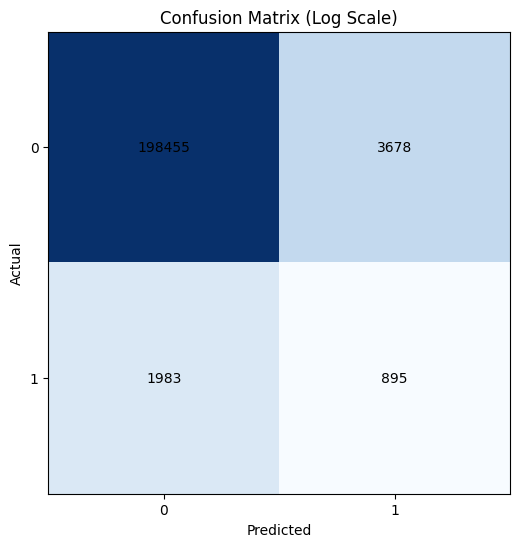

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.colors import LogNorm
cm = confusion_matrix(y_test, y_pred_opt)

plt.figure(figsize=(6,6))
plt.imshow(cm, cmap="Blues", norm=LogNorm())

plt.xticks([0, 1], ['0', '1'])
plt.yticks([0, 1], ['0', '1'])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha='center', va='center', color='black')

plt.title("Confusion Matrix (Log Scale)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

# XGBoost

In [ ]:
X_train_xgb = BAF_train.drop(columns=[y_col])
y_train_xgb = BAF_train[y_col]
X_test = BAF_test.drop(columns=[y_col])
y_test = BAF_test[y_col]

In [ ]:
counts = y_train_xgb.value_counts()
neg = counts.loc[False]
pos = counts.loc[True]
scale = neg / pos

In [ ]:
scaler = StandardScaler()
X_train_xgb_scaled = scaler.fit_transform(X_train_xgb)
X_test__xgb_scaled = scaler.transform(X_test)

In [ ]:
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    random_state=222,
    scale_pos_weight= scale
)

xgb_model.fit(X_train_xgb_scaled, y_train_xgb)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [ ]:
y_pred = xgb_model.predict(X_test__xgb_scaled)
y_proba = xgb_model.predict_proba(X_test__xgb_scaled)[:, 1]

auc = roc_auc_score(y_test, y_proba)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("AUC:", round(auc, 3))
print("Recall:", round(recall, 3))
print("Precision:", round(precision, 3))
print("F1 Score:", round(f1, 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

AUC: 0.89
Recall: 0.768
Precision: 0.065
F1 Score: 0.12

Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.84      0.91    202133
        True       0.07      0.77      0.12      2878

    accuracy                           0.84    205011
   macro avg       0.53      0.81      0.52    205011
weighted avg       0.98      0.84      0.90    205011



# Tunning the XGB Model

In [ ]:
# Recalling this, incase the previous method somehow changed the structure
X_train_xgb = BAF_train.drop(columns=[y_col])
y_train_xgb = BAF_train[y_col]
X_test = BAF_test.drop(columns=[y_col])
y_test = BAF_test[y_col]

In [ ]:
counts = y_train_xgb.value_counts()
neg = counts.loc[False]
pos = counts.loc[True]
scale = neg / pos

In [ ]:
X_train_xgb_scaled = scaler.fit_transform(X_train_xgb)
X_test__xgb_scaled = scaler.transform(X_test)

In [ ]:
xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=222
)

In [ ]:
param_dist = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.25, 0.5, 1],
    'min_child_weight': [1, 3, 5],
    'scale_pos_weight': [scale, scale*0.8, scale*1.2]
}

In [ ]:
rand_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=222,
    n_jobs=-1
)

In [ ]:
rand_search.fit(X_train_xgb_scaled, y_train_xgb)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.8, 0.9, ...], 'gamma': [0, 0.25, ...], 'learning_rate': [0.01, 0.03, ...], 'max_depth': [3, 4, ...], ...}"
,n_iter,20
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,222
,error_score,nan


In [ ]:
print("\nBest Parameters:")
print(rand_search.best_params_)

best_xgb = rand_search.best_estimator_

y_pred = best_xgb.predict(X_test__xgb_scaled)
y_proba = best_xgb.predict_proba(X_test__xgb_scaled)[:, 1]

auc = roc_auc_score(y_test, y_proba)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n=== Test Results (Tuned Model) ===")
print("AUC:", round(auc, 3))
print("Recall:", round(recall, 3))
print("Precision:", round(precision, 3))
print("F1 Score:", round(f1, 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Best Parameters:
{'subsample': 0.9, 'scale_pos_weight': np.float64(77.22615629984051), 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.25, 'colsample_bytree': 0.9}

=== Test Results (Tuned Model) ===
AUC: 0.889
Recall: 0.72
Precision: 0.076
F1 Score: 0.137

Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.87      0.93    202133
        True       0.08      0.72      0.14      2878

    accuracy                           0.87    205011
   macro avg       0.54      0.80      0.53    205011
weighted avg       0.98      0.87      0.92    205011



In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
print(f"Best Threshold for F1: {best_thresh:.3f}")
print(f"Precision: {precisions[best_idx]:.3f}, Recall: {recalls[best_idx]:.3f}, F1: {f1_scores[best_idx]:.3f}")

Best Threshold for F1: 0.886
Precision: 0.228, Recall: 0.293, F1: 0.256


# Try undersample with XGB

In [ ]:
# Recalling this, incase the previous method somehow changed the structure
X_train_xgb = BAF_train.drop(columns=[y_col])
y_train_xgb = BAF_train[y_col]
X_test = BAF_test.drop(columns=[y_col])
y_test = BAF_test[y_col]

In [ ]:
X_train_xgb_scaled = scaler.fit_transform(X_train_xgb)
X_test_xgb_scaled = scaler.transform(X_test)

In [ ]:
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=222)
X_train_under_xgb, y_train_under_xgb = rus.fit_resample(X_train_xgb_scaled, y_train_xgb)

In [ ]:
xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=222
)

In [ ]:
param_dist = {
    'n_estimators': [200, 400, 600, 800, 1000],
    'learning_rate': [0.03, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'min_child_weight': [1, 3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.25, 0.5, 1, 2],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.5, 1, 2, 3],
}

In [ ]:
rand_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=100,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=222,
    n_jobs=-1
)

In [ ]:
rand_search.fit(X_train_under_xgb, y_train_under_xgb)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.7, 0.8, ...], 'gamma': [0, 0.25, ...], 'learning_rate': [0.03, 0.05, ...], 'max_depth': [3, 4, ...], ...}"
,n_iter,100
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,222
,error_score,nan


In [ ]:
print("\nBest Parameters:")
print(rand_search.best_params_)

best_xgb = rand_search.best_estimator_

y_pred = best_xgb.predict(X_test_xgb_scaled)
y_proba = best_xgb.predict_proba(X_test_xgb_scaled)[:, 1]

auc = roc_auc_score(y_test, y_proba)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n=== Test Results (Tuned Model) ===")
print("AUC:", round(auc, 3))
print("Recall:", round(recall, 3))
print("Precision:", round(precision, 3))
print("F1 Score:", round(f1, 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Best Parameters:
{'subsample': 0.9, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 800, 'min_child_weight': 9, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}

=== Test Results (Tuned Model) ===
AUC: 0.872
Recall: 0.371
Precision: 0.149
F1 Score: 0.213

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.97      0.98    202133
        True       0.15      0.37      0.21      2878

    accuracy                           0.96    205011
   macro avg       0.57      0.67      0.60    205011
weighted avg       0.98      0.96      0.97    205011



In [ ]:
xgb_model = XGBClassifier(
    n_estimators=800,
    learning_rate=0.2,
    max_depth=8,
    min_child_weight=9,
    subsample=0.9,
    colsample_bytree=1.0,
    reg_alpha=0.5,
    reg_lambda=0.5,
    gamma=0,
    objective='binary:logistic',
    eval_metric='auc',
    random_state=222
)

xgb_model.fit(X_train_under_xgb, y_train_under_xgb)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [ ]:
y_proba = xgb_model.predict_proba(X_test_xgb_scaled)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_proba)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n=== Test Results (New Tuned Model) ===")
print(f"AUC: {auc:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")
print(f"F1 Score: {f1:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

print(f"\n=== Optimal Threshold Tuning ===")
print(f"Best Threshold for F1: {best_thresh:.3f}")
print(f"Precision: {precisions[best_idx]:.3f}, Recall: {recalls[best_idx]:.3f}, F1: {f1_scores[best_idx]:.3f}")

y_pred_opt = (y_proba >= best_thresh).astype(int)
recall_opt = recall_score(y_test, y_pred_opt)
precision_opt = precision_score(y_test, y_pred_opt)
f1_opt = f1_score(y_test, y_pred_opt)

print("\n=== Final Model Results (After Threshold Adjustment) ===")
print(f"AUC: {auc:.3f}")
print(f"Recall: {recall_opt:.3f}")
print(f"Precision: {precision_opt:.3f}")
print(f"F1 Score: {f1_opt:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_opt))


=== Test Results (New Tuned Model) ===
AUC: 0.872
Recall: 0.371
Precision: 0.149
F1 Score: 0.213

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.97      0.98    202133
        True       0.15      0.37      0.21      2878

    accuracy                           0.96    205011
   macro avg       0.57      0.67      0.60    205011
weighted avg       0.98      0.96      0.97    205011


=== Optimal Threshold Tuning ===
Best Threshold for F1: 0.730
Precision: 0.195, Recall: 0.267, F1: 0.225

=== Final Model Results (After Threshold Adjustment) ===
AUC: 0.872
Recall: 0.267
Precision: 0.195
F1 Score: 0.225

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.98      0.99    202133
        True       0.19      0.27      0.23      2878

    accuracy                           0.97    205011
   macro avg       0.59      0.63      0.61    205011
weighted avg       0.98      0.

In [ ]:
xgb_model_final = XGBClassifier(
    n_estimators=800,
    learning_rate=0.2,
    max_depth=8,
    min_child_weight=9,
    subsample=0.9,
    colsample_bytree=1.0,
    reg_alpha=0.5,
    reg_lambda=0.5,
    gamma=0,
    objective='binary:logistic',
    eval_metric='auc',
    random_state=222
)

In [ ]:
xgb_model_final.fit(X_train_under_xgb, y_train_under_xgb)
y_proba_under = xgb_model_final.predict_proba(X_test_xgb_scaled)[:, 1]

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_under)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]

print(f"\nBest Threshold for F1: {best_thresh:.3f}")
print(f"Precision: {precisions[best_idx]:.3f}, Recall: {recalls[best_idx]:.3f}, F1: {f1_scores[best_idx]:.3f}")

y_pred_opt = (y_proba_under >= best_thresh).astype(int)

auc = roc_auc_score(y_test, y_proba_under)
recall = recall_score(y_test, y_pred_opt)
precision = precision_score(y_test, y_pred_opt)
f1 = f1_score(y_test, y_pred_opt)

print("\n=== Final Model Results (After Undersampling & Threshold Adjustment) ===")
print("AUC:", round(auc, 3))
print("Recall:", round(recall, 3))
print("Precision:", round(precision, 3))
print("F1 Score:", round(f1, 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred_opt))


Best Threshold for F1: 0.730
Precision: 0.195, Recall: 0.267, F1: 0.225

=== Final Model Results (After Undersampling & Threshold Adjustment) ===
AUC: 0.872
Recall: 0.267
Precision: 0.195
F1 Score: 0.225

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.98      0.99    202133
        True       0.19      0.27      0.23      2878

    accuracy                           0.97    205011
   macro avg       0.59      0.63      0.61    205011
weighted avg       0.98      0.97      0.98    205011



# Testing SMOTE

In [ ]:
X_train_bal = BAF_train.drop(columns=[y_col])
y_train_bal = BAF_train[y_col]
X_test = BAF_test.drop(columns=[y_col])
y_test = BAF_test[y_col]

In [ ]:
smote = SMOTE(random_state=222)
X_train_bal, y_train_bal = smote.fit_resample(X_train_bal, y_train_bal)

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

In [ ]:
rf_model.fit(X_train_bal, y_train_bal)

,n_estimators,500
,criterion,'gini'
,max_depth,10
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_proba)

print("\n=== Test Results (Random Forest with SMOTE) ===")
print("AUC:", round(auc, 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


=== Test Results (Random Forest with SMOTE) ===
AUC: 0.835

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.95      0.97    202133
        True       0.10      0.39      0.16      2878

    accuracy                           0.94    205011
   macro avg       0.54      0.67      0.56    205011
weighted avg       0.98      0.94      0.96    205011



# XGBOOST WITH SMOTE

In [ ]:
# Recalling this, incase the previous method somehow changed the structure
X_train_xgb = BAF_train.drop(columns=[y_col])
y_train_xgb = BAF_train[y_col]
X_test = BAF_test.drop(columns=[y_col])
y_test = BAF_test[y_col]

In [ ]:
smote = SMOTE(random_state=222)
X_train_bal, y_train_bal = smote.fit_resample(X_train_xgb, y_train_xgb)

In [ ]:
xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=222
)

In [ ]:
param_dist = {
    'n_estimators': [200, 400, 600, 800, 1000],
    'learning_rate': [0.03, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'min_child_weight': [1, 3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.25, 0.5, 1, 2],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.5, 1, 2, 3],
}

In [ ]:
rand_search_smote_xgb = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=222,
    n_jobs=-1
)

In [ ]:
rand_search_smote_xgb.fit(X_train_bal, y_train_bal)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.7, 0.8, ...], 'gamma': [0, 0.25, ...], 'learning_rate': [0.03, 0.05, ...], 'max_depth': [3, 4, ...], ...}"
,n_iter,50
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,222
,error_score,nan


In [ ]:
rand_search_smote_xgb = XGBClassifier(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='auc',
    scale_pos_weight=scale,
    random_state=222
)

In [ ]:
rand_search_smote_xgb.fit(X_train_bal, y_train_bal)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [ ]:
print("\nBest Parameters:")
print(rand_search.best_params_)

best_xgb = rand_search.best_estimator_

y_pred = best_xgb.predict(X_test_xgb_scaled)
y_proba = best_xgb.predict_proba(X_test_xgb_scaled)[:, 1]

auc = roc_auc_score(y_test, y_proba)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n=== Test Results (Tuned Model) ===")
print("AUC:", round(auc, 3))
print("Recall:", round(recall, 3))
print("Precision:", round(precision, 3))
print("F1 Score:", round(f1, 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Best Parameters:
{'subsample': 0.9, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 800, 'min_child_weight': 9, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}

=== Test Results (Tuned Model) ===
AUC: 0.872
Recall: 0.371
Precision: 0.149
F1 Score: 0.213

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.97      0.98    202133
        True       0.15      0.37      0.21      2878

    accuracy                           0.96    205011
   macro avg       0.57      0.67      0.60    205011
weighted avg       0.98      0.96      0.97    205011

